# Tutorial: How to use ExTrack


In [3]:
import extrack
import numpy as np
from matplotlib import pyplot as plt

simulate tracks able to come and leave from the field of view :

extrack.simulate_tracks.sim_FOV
inputs:
- nb_tracks: number of tracks simulated.
- max_track_len: number of steps simulated per track.
- LocErr: standard deviation of the localization error.
- Ds: 1D array of the diffusion coefs for each state.
- TrMat: transition array per step (lines: state at time n, cols: states at time n+1).
- dt: time in between frames.
- pBL: probability of bleaching per step.
- cell_dims: dimension limits in x, y and z respectively. x, y dimension limits are useful when tracking membrane proteins in tirf when the particles leave the field of view from the sides of the cells. z dimension is relevant for cytoplasmic proteins which can leave from the z axis. Consider the particle can leave from both ends of each axis: multiply axis limit by 2 to aproximate tracks leaving from one end.
- min_len: minimal track length for the track to be considered.

outputs:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- all_Bs: dict descibing the true states of tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.

In [5]:
dt = 0.025
all_tracks, all_Bs = extrack.simulate_tracks.sim_FOV(nb_tracks=2000,#increase this number to simulate more tracks and gain in precision
                                                     max_track_len=60,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     cell_dims = [1,None,None],
                                                     min_len = 21)

number of tracks:
0 pos : 472, 1 pos : 389, 2 pos : 328, 3 pos : 309, 4 pos : 211, 5 pos : 233, 6 pos : 184, 7 pos : 188, 8 pos : 151, 9 pos : 99, 10 pos : 97, 11 pos : 87, 12 pos : 83, 13 pos : 59, 14 pos : 57, 15 pos : 41, 16 pos : 39, 17 pos : 32, 18 pos : 41, 19 pos : 29, 20 pos : 19, 21 pos : 27, 22 pos : 22, 23 pos : 13, 24 pos : 12, 25 pos : 14, 26 pos : 9, 27 pos : 10, 28 pos : 8, 29 pos : 4, 30 pos : 4, 31 pos : 9, 32 pos : 11, 33 pos : 1, 34 pos : 3, 35 pos : 4, 36 pos : 5, 38 pos : 2, 39 pos : 8, 

fitting the parameters to the data set:

extrack.tracking.get_2DSPT_params
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- dt: time in between frames.
- cell_dims: dimension limits (um).
- nb_substeps: number of virtual transition steps in between consecutive 2 positions.
- nb_states: number of states. estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- frame_len: number of frames for which the probability is perfectly computed. See method of the paper for more details.
- verbose: if 1, print the intermediate values for each iteration of the fit.
- steady_state: True if tracks are considered at steady state (fractions independent of time), this is most likely not true as tracks join and leave the FOV.
- vary_params: dict specifying if each parameters should be changed (True) or not (False).
- estimated_vals: initial values of the fit. (stay constant if parameter fixed by vary_params). estimated_vals must be in between min_values and max_values even if fixed.
- min_values: minimal values for the fit.
- max_values: maximal values for the fit.

outputs:
- model_fit: lmfit model

In [6]:
model_fit = extrack.tracking.get_2DSPT_params(all_tracks,
                                              dt,
                                              cell_dims = [1],
                                              nb_substeps = 2,
                                              nb_states = 2,
                                              frame_len = 7,
                                              verbose = 0,
                                              workers = 1, # increase the number of CPU workers for faster computing, do not work on windows
                                              steady_state = False,
                                              vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : False, 'p01' : True, 'p10' : True, 'pBL' : True},
                                              estimated_vals = {'LocErr' : 0.020, 'D0' : 0, 'D1' : 0.5, 'F0' : 0.6, 'p01' : 0.1, 'p10' : 0.1, 'pBL' : 0.1},
                                              min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.01, 'p10' : 0.01, 'pBL' : 0.01},
                                              max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99})

Parameters([('D0', <Parameter 'D0', value=1e-12, bounds=[1e-12:1]>), ('D1_minus_D0', <Parameter 'D1_minus_D0', value=0.5, bounds=[9.999999000000001e-06:10]>), ('D1', <Parameter 'D1', value=0.500000000001, bounds=[-inf:inf], expr='D0 + D1_minus_D0'>), ('LocErr', <Parameter 'LocErr', value=0.02, bounds=[0.007:0.6]>), ('F0', <Parameter 'F0', value=0.6 (fixed), bounds=[0.001:0.999]>), ('p01', <Parameter 'p01', value=0.1, bounds=[0.01:1.0]>), ('p10', <Parameter 'p10', value=0.1, bounds=[0.01:1.0]>), ('pBL', <Parameter 'pBL', value=0.1, bounds=[0.01:0.99]>)])
.....................................................................................................................................................................

produces histograms of time spent in each state :

extrack.visualization.visualize_states_durations
inputs:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- params: lmfit parameters used for the model.
- dt: time in between frames.
- cell_dims: dimension limits (um). estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- max_nb_states: maximum number of sequences kept (most likely sequences).
- nb_steps_lim: upper limit of the plot in the x axis (number of steps)
- long_tracks: if True only selects tracks longer than nb_steps_lim
- steps: x axis in seconds if False or in number of steps if False.

outputs:
- plot of all tracks (preferencially input a single movie)

.......................................
state 0: -0.07923452267393001
state 1: -0.16998918188666856


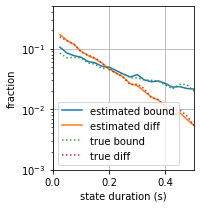

In [7]:
extrack.visualization.visualize_states_durations(all_tracks,
                                                 params = model_fit.params,
                                                 dt = dt,
                                                 cell_dims = [1],
                                                 nb_states = 2,
                                                 max_nb_states = 200,
                                                 long_tracks = True,
                                                 nb_steps_lim = 20,
                                                 steps = False)

# ground truth histogram (actual labeling from simulations) :

seg_len_hists = extrack.histograms.ground_truth_hist(all_Bs, 2)
plt.plot(np.arange(1,len(seg_len_hists)+1)[:,None]*dt, seg_len_hists/np.sum(seg_len_hists,0), ':')
plt.legend(['estimated bound','estimated diff','true bound','true diff'])
# assesment of the slops of the histograms :

print('state 0:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,0], 1)[0])
print('state 1:', np.polyfit(np.arange(1,len(seg_len_hists))[3:15], np.log(seg_len_hists[3:15])[:,1], 1)[0])

In [6]:
# if someone wants to run a an analysis with specific values, they can either fixe all parameters of the fit
# or use the following function :

params = extrack.tracking.get_params(nb_states = 2,
                                     steady_state = False,
                                     vary_params = {'LocErr' : True, 'D0' : True, 'D1' : True, 'F0' : True, 'p01' : True, 'p10' : True, 'pBL' : True},
                                     estimated_vals = {'LocErr' : 0.025, 'D0' : 1e-20, 'D1' : 0.5, 'F0' : 0.45, 'p01' : 0.1, 'p10' : 0.1, 'pBL' : 0.1},
                                     min_values = {'LocErr' : 0.007, 'D0' : 1e-12, 'D1' : 0.00001, 'F0' : 0.001, 'p01' : 0.01, 'p10' : 0.01, 'pBL' : 0.01},
                                     max_values = {'LocErr' : 0.6, 'D0' : 1, 'D1' : 10, 'F0' : 0.999, 'p01' : 1., 'p10' : 1., 'pBL' : 0.99})

states preditions by ExTrack :

extrack.tracking.predict_Bs
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- params: lmfit parameters used for the model.
- dt: time in between frames.
- cell_dims: dimension limits (um). estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- nb_states: number of states. estimated_vals, min_values, max_values should be changed accordingly to describe all states and transitions.
- frame_len: number of frames for which the probability is perfectly computed. See method of the paper for more details.

outputs:
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.

In [7]:

# simulation of fiewer tracks to plot them and their annotation infered by ExTrack :

all_tracks, all_Bs = extrack.simulate_tracks.sim_FOV(nb_tracks=500,
                                                     max_track_len=60,
                                                     LocErr=0.02,
                                                     Ds = np.array([0,0.5]),
                                                     initial_fractions = np.array([0.6,0.4]),
                                                     TrMat = np.array([[0.9,0.1],[0.1,0.9]]),
                                                     dt = dt,
                                                     pBL = 0.1,
                                                     cell_dims = [1,], # dimension limits in x, y and z respectively
                                                     min_len = 11)

# performs the states probability predictions based on the most likely parameters :

pred_Bs = extrack.tracking.predict_Bs(all_tracks,
                                      dt,
                                      model_fit.params,
                                      cell_dims=[1],
                                      nb_states=2,
                                      frame_len=12)


number of tracks:
0 pos : 29, 1 pos : 19, 2 pos : 22, 3 pos : 15, 4 pos : 16, 5 pos : 11, 6 pos : 7, 7 pos : 9, 8 pos : 9, 9 pos : 7, 10 pos : 5, 11 pos : 5, 12 pos : 4, 13 pos : 6, 14 pos : 4, 16 pos : 2, 17 pos : 3, 18 pos : 2, 19 pos : 1, 20 pos : 1, 22 pos : 3, 23 pos : 1, 24 pos : 1, 28 pos : 1, 30 pos : 1, 32 pos : 1, 37 pos : 1, 42 pos : 1, 

turn outputs from extrack to a more classical data frame format :

extrack.exporters.extrack_2_pandas
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- frames: dict describing the frame of each position of each track with keys track length (number of time positions, e.g. '23') of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- opt_metrics: dict of dicts for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. {'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}

outputs:
- DATA: pandas dataframe containing the necessary informations for each track

In [8]:

DATA = extrack.exporters.extrack_2_pandas(all_tracks, pred_Bs, frames = None, opt_metrics = {})


show all tracks on top of each other

extrack.visualization.visualize_tracks
arguments:
- DATA: dataframe outputed by extrack.exporters.extrack_2_pandas
- track_length_range: range of tracks ploted. plotting too many tracks may make it crash
- figsize: size of the figure plotted

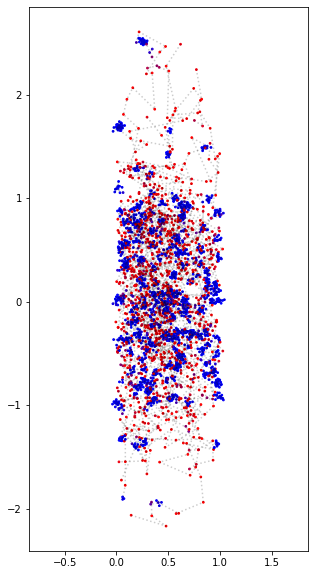

In [9]:
# show all tracks :

extrack.visualization.visualize_tracks(DATA,
                                       track_length_range = [10,np.inf],
                                       figsize = (5,10))

show the longest tracks in more details :
extrack.visualization.plot_tracks

arguments:
- DATA: dataframe outputed by extrack.exporters.extrack_2_pandas.
- max_track_length: maximum track length to be outputed, it will plot the longest tracks respecting this criteria.
- nb_subplots: number of lines and columns of subplots.
- figsize: size of the figure plotted

..


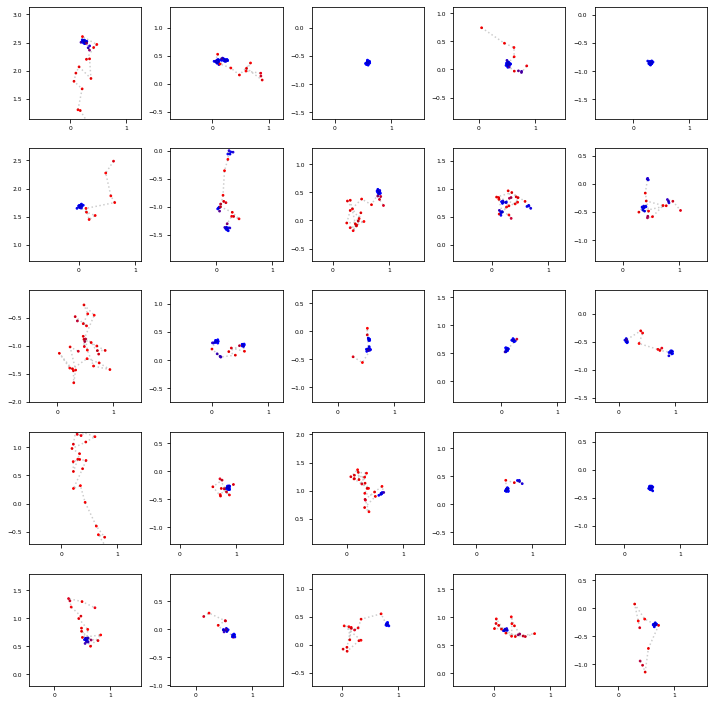

In [10]:
# show the longest tracks in more details :

extrack.visualization.plot_tracks(DATA,
                                  max_track_length = 50,
                                  nb_subplots = [5,5],
                                  figsize = (10,10), 
                                  lim = 1)

save tracks as either xml file used by trackmate or in a CSV file.
extrack.exporters.save_extrack_2_xml
arguments:
- all_tracks: dict describing the tracks with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = x, y position.
- pred_Bs: dict describing the state probability of each track for each time position with track length as keys (number of time positions, e.g. '23') of 3D arrays: dim 0 = track, dim 1 = time position, dim 2 = state.
- params: lmfit parameters
- path: path + name of the saved file
- dt: time in between frames.
- all_frames: dict describing the frame of each position of each track with keys track length (number of time positions, e.g. '23') of 2D arrays: dim 0 = track, dim 1 = time position, assumed to go from 0 to number of time positions - 1 if none.
- opt_metrics: dict of dicts for each specified optional metric to add to the dataframe. each array must be a 2D array of dims 0 = tracks, dim 1 = time position. e.g. {'QUALITY': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...])}, 'SNR': {'5':np.array([...]), '6':np.array([...]), '7':np.array([...]) }}

In [12]:
# save as xml file used for trackmate :

save_path = './tracks.xml' 
extrack.exporters.save_extrack_2_xml(all_tracks,
                                     pred_Bs,
                                     params = model_fit.params,
                                     path = save_path,
                                     dt = dt,
                                     all_frames = None,
                                     opt_metrics = {})

# save as csv file :
save_path = '/home/oem/Downloads/tracks.csv' 
DATA.to_csv(save_path)
